In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

In [152]:
#Simulate 3 years (1095) of data
np.random.seed(42)
dates = pd.date_range(start='2022-01-01', periods=1095, freq='D')

In [153]:
# Base Level + Trend + Seasonality + Noise
trend = np.linspace(100, 150, 1095)  # Linear trend
yearly_seasonality = 20 * np.sin(np.arange(1095) / 365 * 2 * np.pi + 1.5)  # Yearly seasonality
noise = np.random.normal(0, 8, 1095)  # Random noise
sales = trend + yearly_seasonality + noise

In [154]:
#Create Time Series DataFrame (Prophet requires 'ds' and 'y' columns)
sales = trend + yearly_seasonality + noise
sales_df = pd.DataFrame({'ds': dates, 'y': sales})
sales_df['y'] = sales_df['y'].clip(lower=0)  # Ensure no negative sales

<Figure size 1000x800 with 0 Axes>

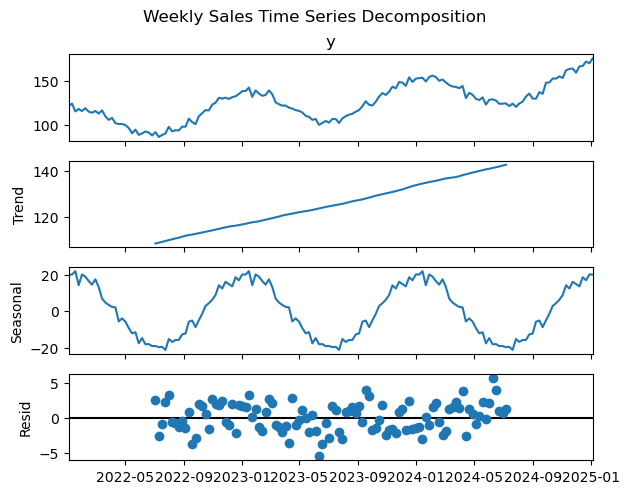

In [155]:
# Time Series Decompisition Plot
#resample to weekly data for a smoother view of the trend and seasonality
df_weekly = sales_df.set_index('ds').resample('W').mean().dropna()
#Decompose the series
decomposition = seasonal_decompose(df_weekly['y'], model='additive', period=52)
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.suptitle('Weekly Sales Time Series Decomposition', y=1.02)
plt.show()

In [156]:
# Initialize and fit Prophet Model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative'
)
m.fit(sales_df)

12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing


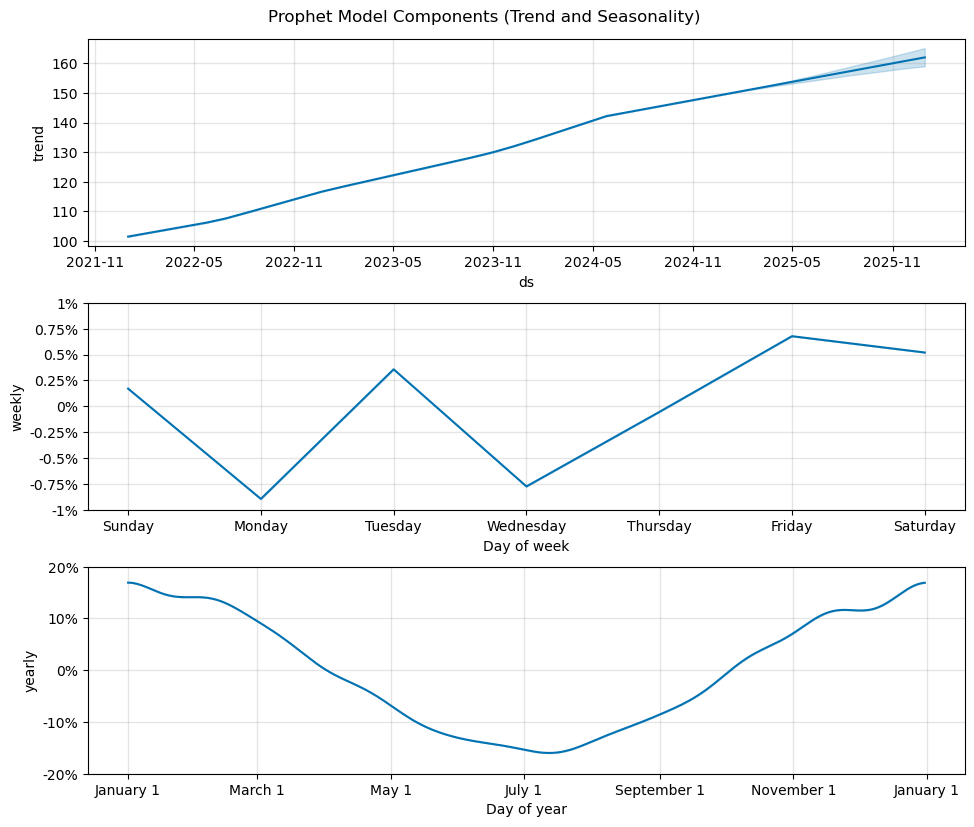

In [157]:
#Visualize Models Detected Seasonality and Trend(Insights)
#Shows how Prophet is interpreting datas components
future_comp = m.make_future_dataframe(periods=365)
forecast = m.predict(future_comp)
fig = m.plot_components(forecast)
fig.set_size_inches(10, 8)
fig.suptitle('Prophet Model Components (Trend and Seasonality)', y=1.02)
plt.show()

In [158]:
# Extracting Actionable inventory recommendations
# 1. Filter the forecast DataFrame for the next 90 days
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime('2025-01-01') + pd.Timedelta(days=89)
inventory_forecast = forecast[
    (forecast['ds'] >= start_date) & 
    (forecast['ds'] <= end_date)
]

In [159]:
# 2. Calculate the average forecasted sales for the 90 day period(yhat)
total_forecasted_sales = inventory_forecast['yhat'].sum()
# 3. calculate the total quantity needed to for the 90 day period (yhat_upper)
recommended_order_quantity = inventory_forecast['yhat_upper'].sum()
# 4. Calculate the inventory buffer (risk buffer)
# Shows extra stock required over the simple forecast
inventory_buffer = recommended_order_quantity - total_forecasted_sales

In [160]:
print(f"Recommended Inventory for January 2025 - March 2025 (90 days)")
print(f"Total Expected Demand (yhat): {total_forecasted_sales:.0f} units")
print(f"Recommended Order Quantity (yhat_upper, 95% CI): {recommended_order_quantity:.0f} units")
print(f"Inventory Buffer (Risk Coverage): {inventory_buffer:.0f} units")
print (f"This buffer represents {(inventory_buffer / total_forecasted_sales) * 100:.1f}% safety stock over the expected demand")


Recommended Inventory for January 2025 - March 2025 (90 days)
Total Expected Demand (yhat): 15079 units
Recommended Order Quantity (yhat_upper, 95% CI): 15974 units
Inventory Buffer (Risk Coverage): 895 units
This buffer represents 5.9% safety stock over the expected demand
